c:\Users\liao\PycharmProjects\pythonProject1\AAA.Graduate work\Fittng_lastversion\mrk290#5\../..\sagan\stellar_continuum.py:43: RuntimeWarning: invalid value encountered in log
  logf_star_A0V = np.interp(logw_even_kpa, logw_star, np.log(flux_A0V))


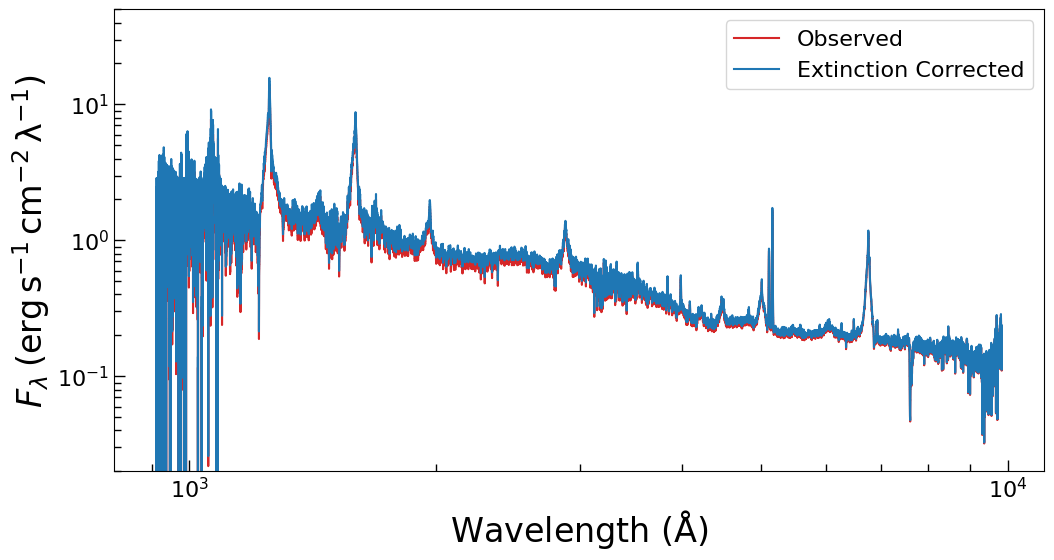

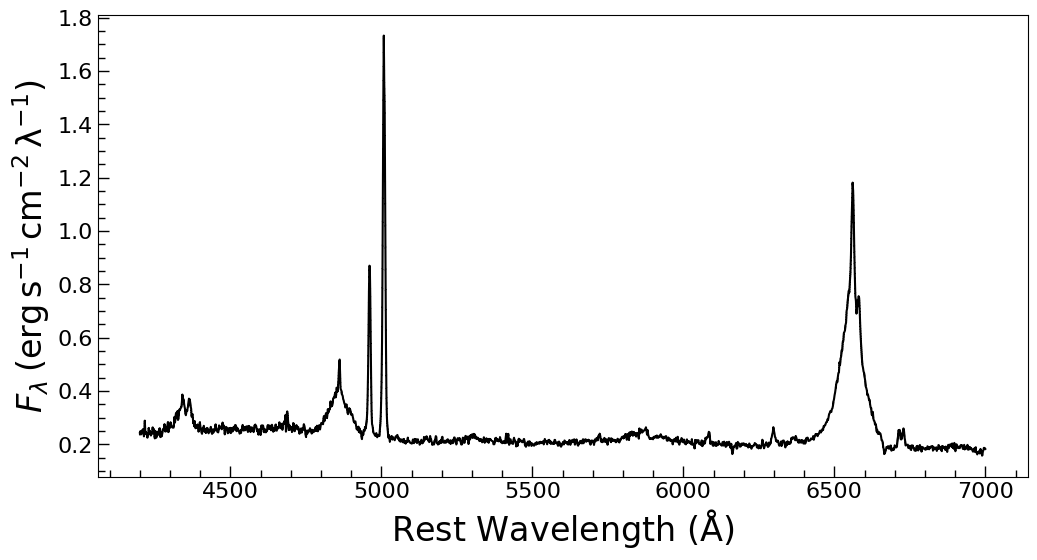

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

from astropy.modeling import models, fitting
import sys
sys.path.append("../..")
import sagan

import matplotlib as mpl
mpl.rc("xtick", direction="in", labelsize=16)
mpl.rc("ytick", direction="in", labelsize=16)
mpl.rc("xtick.major", width=1., size=8)
mpl.rc("ytick.major", width=1., size=8)
mpl.rc("xtick.minor", width=1., size=5)
mpl.rc("ytick.minor", width=1., size=5)

# automatic reload the modules
%load_ext autoreload
%autoreload 2

ls_km = 2.99792e5 # km/s
datapath = 'data'
hdul = fits.open('mrk290sed.fit')#---------------------------修改文件名
header = hdul[0].header
flux = hdul[0].data * 1e14

w0 = header['CRVAL1']
dw = header['CD1_1']
wave = w0 + dw*np.arange(flux.size)

# Find the V band attenuation from https://ned.ipac.caltech.edu/ -- FOREGROUND GALACTIC EXTINCTION
from extinction import ccm89, remove

A_V = 0.04    #------------------------------修改 消光系数
flux_dred = remove(ccm89(wave, A_V, r_v=3.1, unit='aa'), flux)

fig, ax = plt.subplots(figsize=(12, 6))
ax.step(wave, flux, label='Observed', c='C3')
ax.step(wave, flux_dred, label='Extinction Corrected', c='C0')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'Wavelength ($\mathrm{\AA}$)', fontsize=24)
ax.set_ylabel(r'$F_\lambda\:(\mathrm{erg\,s^{-1}\,cm^{-2}\,\lambda^{-1}})$', fontsize=24)
ax.legend(fontsize=16)
ax.set_ylim(0.02, 50)#-------------------------------修改y可见范围
ax.minorticks_on()
plt.show()
zred = 0.0303 #-------------------------------------修改红移

fig, ax = plt.subplots(figsize=(12, 6))
wmin, wmax = 4200, 7000
wave_rst = wave / (1 + zred)
fltr = (wave_rst > wmin) & (wave_rst < wmax)
wave_use = wave_rst[fltr]
flux_use = flux_dred[fltr]

ax.step(wave_use, flux_use, color='k')
ax.set_xlabel(r'Rest Wavelength ($\mathrm{\AA}$)', fontsize=24)
ax.set_ylabel(r'$F_\lambda\:(\mathrm{erg\,s^{-1}\,cm^{-2}\,\lambda^{-1}})$', fontsize=24)
ax.minorticks_on()
plt.show()

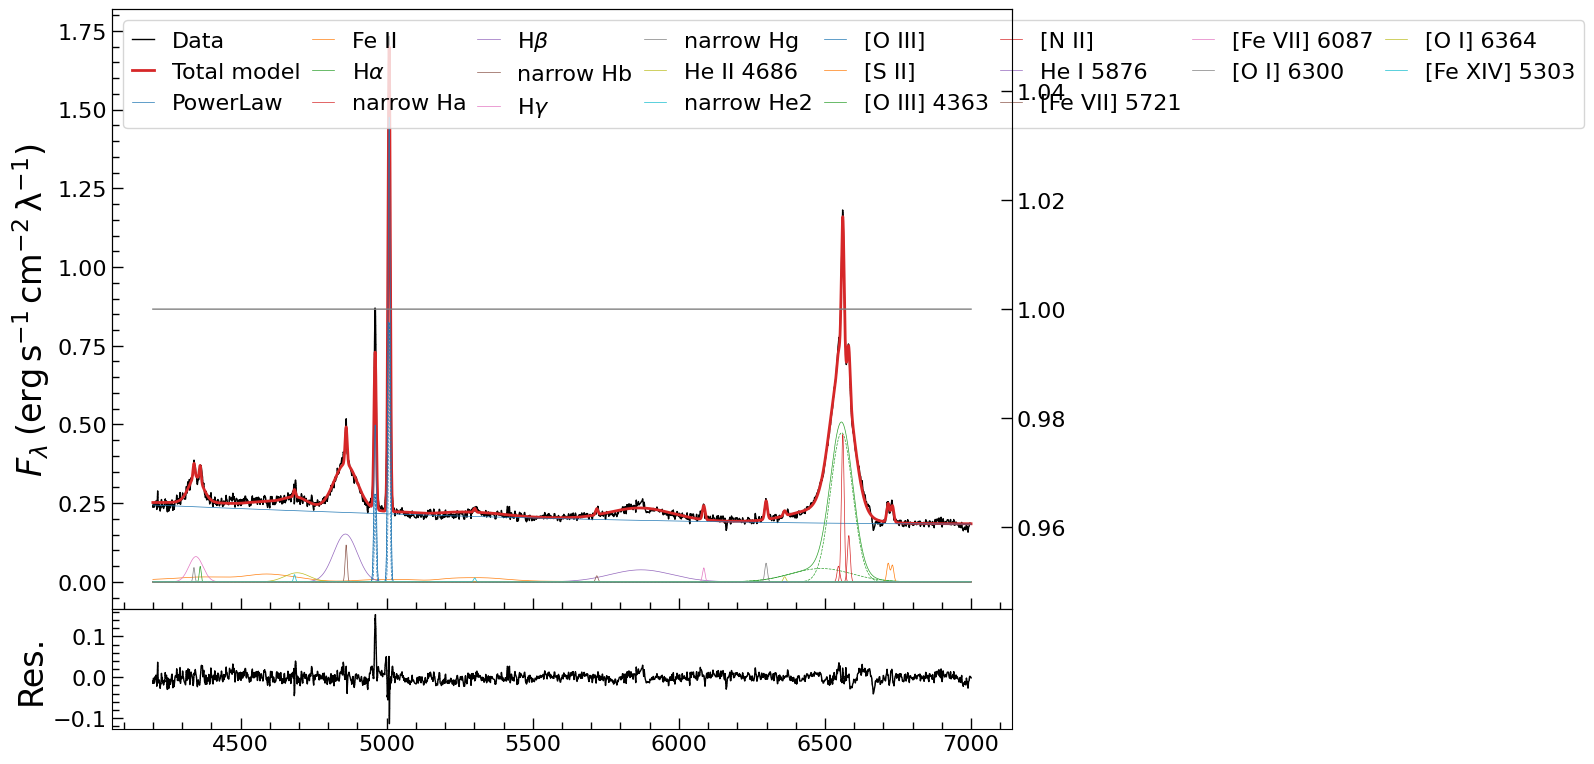

<PowerLaw1D(amplitude=0.45226653, x_0=5500., alpha=0.0093927, name='PowerLaw')>
<IronTemplate(amplitude=0.07878627, stddev=3565.59, z=0.0089876, name='Fe II')>
<Line_MultiGauss(amp_c=1.14951797, dv_c=-263.35779405, sigma_c=1742.53140374, wavec=6562.819, amp_w0=0.08935303, dv_w0=-3144.03118431, sigma_w0=4750.55872194, name='H$\\alpha$')>
<Line_Gaussian(amplitude=1.13591461, dv=-84.23049605, sigma=216.94772777, wavec=6562.819, name='narrow Ha')>
<Line_MultiGauss(amp_c=0.31211337, dv_c=-214.49432136, sigma_c=2486.55567639, wavec=4862.721, name='H$\\beta$')>
<Line_Gaussian(amplitude=0.24055204, dv=-84.23049605, sigma=216.94772777, wavec=4862.721, name='narrow Hb')>
<Line_MultiGauss(amp_c=0.15259139, dv_c=383.19960641, sigma_c=1678.23932542, wavec=4341.785, name='H$\\gamma$')>
<Line_Gaussian(amplitude=0.08647262, dv=-84.23049605, sigma=216.94772777, wavec=4341.785, name='narrow Hg')>
<Line_MultiGauss(amp_c=0.05793959, dv_c=500., sigma_c=2719.06967979, wavec=4686., name='He II 4686')>
<Line_

In [15]:
#------------------------------------------------------------具体拟合，修改各成分
wave_dict = sagan.utils.line_wave_dict
label_dict = sagan.utils.line_label_dict

poly = models.Polynomial1D(degree=2, name='multi') 
pl = models.PowerLaw1D(amplitude=0.45226653, x_0=5500, alpha=0.0093927, fixed={'x_0': True,'amplitude':True,'alpha':True},name='PowerLaw')
iron = sagan.IronTemplate(amplitude=0.07878627, stddev=3565.59, z=0, name='Fe II',fixed={'amplitude':True,'stddev':True})

bounds = {'sigma_w0': (100, 4000)}
#b_ha = sagan.Line_MultiGauss(n_components=1, amp_c=2.22, dv_c=300, sigma_c=830, 
#                             wavec=wave_dict['Halpha'], name=label_dict['Halpha'])
b_ha = sagan.Line_MultiGauss(n_components=2, amp_c=0.5, dv_c=-160, sigma_c=1700, 
                             wavec=wave_dict['Halpha'], name=label_dict['Halpha'],
                             amp_w0=0.08, dv_w0=-4000, sigma_w0=4300)

# It took me quite some time to adjust the 

b_hb = sagan.Line_MultiGauss(n_components=1, amp_c=0.16, dv_c=-280, sigma_c=2000, 
                             wavec=wave_dict['Hbeta'], name=label_dict['Hbeta'],bounds=bounds)
#b_hb = sagan.Line_MultiGauss(n_components=2, amp_c=0.16, dv_c=-277, sigma_c=2000, 
#                             wavec=wave_dict['Hbeta'], name=label_dict['Hbeta'],
#                             amp_w0=0.3, dv_w0=2000, sigma_w0=3700, bounds=bounds)
b_hg = sagan.Line_MultiGauss(n_components=1, amp_c=0.08, dv_c=300, sigma_c=1700, 
                             wavec=wave_dict['Hgamma'], name=label_dict['Hgamma'])


bounds = {'sigma_c': (100, 4000), 'dv_c': (-500, 500)}
b_he2 = sagan.Line_MultiGauss(n_components=1, amp_c=0.024, dv_c=500, sigma_c=3500, 
                              wavec=wave_dict['HeII_4686'], name=label_dict['HeII_4686'], 
                              bounds=bounds)
b_he1 = sagan.Line_MultiGauss(n_components=1, amp_c=0.035, dv_c=-450, sigma_c=5000, wavec=5875.624, name='He I 5876')  # Masked

line_o3 = sagan.Line_MultiGauss_doublet(n_components=2, amp_c0=0.8, amp_c1=0.27, dv_c=-83, sigma_c=210, 
                                        wavec0=wave_dict['OIII_5007'], wavec1=wave_dict['OIII_4959'], name='[O III]',
                                        amp_w0=1, dv_w0=200, sigma_w0=200)

line_s2 = sagan.Line_MultiGauss_doublet(n_components=1, amp_c0=0.06, amp_c1=0.05,
                                        wavec0=wave_dict['SII_6718'], wavec1=wave_dict['SII_6733'], name='[S II]')

# Usually we need [N II] 6548, 6583, but I cannot get a non-zero value for this doublet for this target
line_n2 = sagan.Line_MultiGauss_doublet(n_components=1, amp_c0=0.15, amp_c1=0.05, dv_c=-80, sigma_c=210,
                                        wavec0=wave_dict['NII_6583'], wavec1=wave_dict['NII_6548'], name='[N II]')



n_ha = sagan.Line_Gaussian(amplitude=0.44, wavec=wave_dict['Halpha'], name=f'narrow Ha')
n_hb = sagan.Line_Gaussian(amplitude=0.08, wavec=wave_dict['Hbeta'], name=f'narrow Hb')
n_hg = sagan.Line_Gaussian(amplitude=0.05, wavec=wave_dict['Hgamma'], name=f'narrow Hg')
n_he2 = sagan.Line_Gaussian(amplitude=0.028, wavec=wave_dict['HeII_4686'], name=f'narrow He2')
n_o3_4363 = sagan.Line_Gaussian(amplitude=0.05, wavec=wave_dict['OIII_4363'], name=f'[O III] 4363')


n_fe14_5303 = sagan.Line_Gaussian(amplitude=0.0097, wavec=wave_dict['FeXIV_5303'], name=f'[Fe XIV] 5303')
n_fe7_5721 = sagan.Line_Gaussian(amplitude=0.017, wavec=wave_dict['FeVII_5721'], name=f'[Fe VII] 5721')
n_fe7_6087 = sagan.Line_Gaussian(amplitude=0.04, wavec=wave_dict['FeVII_6087'], name=f'[Fe VII] 6087')
n_o1_6300 = sagan.Line_Gaussian(amplitude=0.05, wavec=wave_dict['OI_6300'], name=f'[O I] 6300')
n_o1_6364 = sagan.Line_Gaussian(amplitude=0.01, wavec=wave_dict['OI_6364'], name=f'[O I] 6364')



line_ha  =  b_ha + n_ha
line_hb  =  b_hb + n_hb
line_hg  =  b_hg + n_hg
line_he2 =  b_he2 + n_he2
line_he1 =  b_he1  # Masked

m_init = (pl + iron+line_ha+line_hb  + line_hg + line_he2 + line_o3  + line_s2 + n_o3_4363+line_n2+line_he1+n_fe7_5721+n_fe7_6087+n_o1_6300+n_o1_6364+n_fe14_5303 )*poly
# + line_ha+line_hb  + line_hg + line_he2 + line_o3  + line_s2 + n_o3_4363+line_n2+line_he1+n_fe7_5721+n_fe7_6087+n_o1_6300+n_o1_6364+n_fe14_5303

# Tie the line ratio of [O III] 5007/4959 to 2.98
def tie_o3(model):
    return model['[O III]'].amp_c0 / 2.98
line_o3.amp_c1.tied = tie_o3

def tie_n2(model):
    return model['[N II]'].amp_c0 / 2.96
line_n2.amp_c1.tied = tie_n2

# Tie
def tie_narrow_sigma(model):
    return model['[O III]'].sigma_c

def tie_narrow_dv(model):
    return model['[O III]'].dv_c

line_s2.sigma_c.tied = tie_narrow_sigma
line_s2.dv_c.tied = tie_narrow_dv
line_n2.sigma_c.tied = tie_narrow_sigma
line_n2.dv_c.tied = tie_narrow_dv

for line in [n_ha, n_hb, n_hg, n_he2, n_o3_4363,n_fe7_5721,n_fe7_6087,n_o1_6300,n_o1_6364,n_fe14_5303]:
    line.sigma.tied = tie_narrow_sigma
    line.dv.tied = tie_narrow_dv


fitter = fitting.LevMarLSQFitter()

weights = np.ones_like(flux_use)
fltr1 = (wave_use > 6900) & (wave_use < 7000)
#fltr2 = (wave_use > 4976) & (wave_use < 4991)
fltr3 = (wave_use > 6646) & (wave_use < 6685)
fltr11= (wave_use > 4260) & (wave_use < 4430)
fltr12= (wave_use > 4600) & (wave_use < 5080)
fltr13= (wave_use > 5650) & (wave_use < 6050)
fltr14= (wave_use > 6200) & (wave_use < 6790)

#weights[fltr1] = 0
#weights[fltr2] = 0
#weights[fltr3] = 0
#weights[fltr11] = 0
#weights[fltr12] = 0
#weights[fltr13] = 0
#weights[fltr14] = 0

m_fit = fitter(m_init, wave_use, flux_use, weights=weights, maxiter=10000)  # Important to set a large maxiter!

ax, axr = sagan.plot.plot_fit(wave_use, flux_use, m_fit, weight=weights)
ax.set_ylabel(r'$F_\lambda\:(\mathrm{erg\,s^{-1}\,cm^{-2}\,\lambda^{-1}})$', fontsize=24)
plt.show()

for m in m_fit:
    print(m.__repr__())